#  Práctica Calificada 4: Ajuste de parámetros en Algoritmos Genéticos

Alumno: Jordi Joel Bardales Rojas

##### Importando librerías

In [ ]:
from __future__ import annotations
import random
import matplotlib.pyplot as plt
from typing import Callable
from typing import NamedTuple
import copy
import numpy as np
import math
from abc import ABC, abstractmethod

##### Utilidades para la conversión a binario/gray

In [1]:
def dec2bin(num: int, bits: int) -> list[int]:
    bin = [0] * bits
    index = 0
    while True:
        bin[index] = num % 2
        if num // 2 <= 0:
            break
        num = num // 2
        index += 1
    return bin[::-1]

def bin2dec(my_bin: list[int]) -> int:
    num = 0
    for i, b in enumerate(reversed(my_bin)):
        num = num + b * 2**i
    return num

def bin2gray(my_bin: list[int]) -> list[int]:
    my_gray = [my_bin[0]]
    for i in range(1, len(my_bin)):
        my_gray.append(my_bin[i - 1] ^ my_bin[i])
    return my_gray

def gray2bin(my_gray: list[int]) -> list[int]:
    # recursive version
    my_bin = [my_gray[0]]
    for k in range(1, len(my_gray)):
        my_bin.append(my_gray[k] ^ my_bin[k - 1])
    return my_bin

def show(my_bin):
    return "".join(str(e) for e in my_bin)

def my_map(x, a, b, epsilon) -> int:
    if a <= x and x <= b:
        u = round((x - a) / epsilon)
        return u
    return a if a < x else b

def inverse_map(u, a, epsilon) -> int:
    return u * epsilon + a


Se modificó la clase individuo de prácticas anteriores para que cada individuo tenga una edad la cual se incrementa en cada generación. La edad cuando un individuo nace es 0. 

In [2]:
class IndividualArguments(NamedTuple):
    domain: tuple[int, int]
    eps: float
    n_var: int
    age: int
    gen_size: int

class Individual():
    def __init__(self, phenotype: list[float], args: IndividualArguments):
        self.domain = args.domain
        self.eps = args.eps
        self.n_var = args.n_var
        # la edad es el número de generaciones que ha pasado desde que el individuo fue creado
        self.age = args.age
        self.gen_size = args.gen_size
        self.phenotype = phenotype

    def getGenotype(self):
        list_repr: list[int] = []
        for gen in self.phenotype:
            list_repr.extend(bin2gray(dec2bin(num=my_map(gen, self.domain[0], self.domain[1], self.eps), bits=self.gen_size)))
        return list_repr

    @classmethod
    def new(cls, genotype, args: IndividualArguments):
        phenotype: list[int] = []
        for k in range(args.n_var):
            gen = genotype[args.gen_size * k:args.gen_size * (k + 1)]
            phenotype.append(inverse_map(bin2dec(gray2bin(gen)), args.domain[0], args.eps))
        return cls(phenotype, args)

    @staticmethod
    def newLike(genotype: list[int], parent: Individual):
        # los individuos cuando nacen tienen edad 0
        args = IndividualArguments(parent.domain, parent.eps, parent.n_var, 0, parent.gen_size)
        return Individual.new(genotype, args)

    @classmethod
    def newRandom(cls, args: IndividualArguments):
        phenotype = [round(random.uniform(args.domain[0], args.domain[1]), 6) for _ in range(args.n_var)]
        return cls(phenotype, args)


## 1. Ajuste de parámetros en Algoritmos Genéticos (AG)

Para la siguiente función no convexa de dominio continuo

$$f(x, y)=3\left(1-x^{2}\right) e^{-x^{2}-(y+1)^{2}}-\frac{e^{-(x+1)^{2}-y^{2}}}{3}-10\left(\frac{x}{5}-x^{3}-y^{5}\right) e^{-x^{2}-y^{2}}$$

donde $x ∈ [−3, 3]$ e $y ∈ [−3, 3]$ y que contiene mas de mínimo local. Se pide lo siguiente:

In [3]:
# función 1
F1 = lambda x: 3 * (1 - x[0]**2) * math.exp(-x[0]**2 - (x[1] + 1)**2) - math.exp(-(x[0] + 1)**2 - x[1]**2) / 3 - 10 * (x[0] / 5 - x[0]**3 - x[1]**5) * math.exp(-x[0]**2 - x[1]**2)
# dominio
domain_1, n_var_1 = [-3, 3], 2
# tamaño del gen
GEN_SIZE_1 = 19
# precisión
eps_1 = (domain_1[1] - domain_1[0]) / (2**GEN_SIZE_1 - 1)
# los los individuos nacen con una edad 0, en cada generación esta se incrementa
age_1 = 0   
# argumentos para el experimento 1
args_1 = IndividualArguments(domain_1, eps_1, n_var_1, age_1, GEN_SIZE_1)
# numero de puntos
points_1 = int((domain_1[1] - domain_1[0]) / eps_1) + 1


#### 1. [1 punto] representar gráficamente la función
***Respuesta***

Gráfica 1: Curvas de nivel. En la barra de color se observa que el valor mínimo es aproximadamente -6 y el máximo 7.5 en el intervalo dado. El punto rojo es el mínimo encontrado con el algoritmo genético.

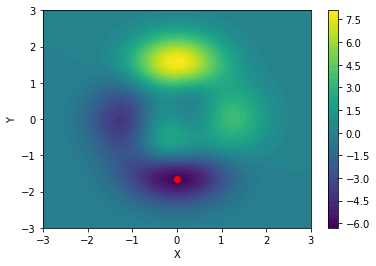

In [4]:
# intervalo con 50 puntos para la gráfica
interval_1 = np.linspace(*domain_1, 50)
z_points = np.zeros((50, 50))

for i, x in enumerate(interval_1):
    for j, y in enumerate(interval_1):
        z_points[j, i] = F1([interval_1[i], interval_1[j]])

plt.contourf(interval_1, interval_1, z_points, 50)
# punto rojo encontrado con el algoritmo evolutivo 
plt.plot(0.012868905771075578, -1.6604665002183918, 'o', c='r')
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar()
plt.show()

Gráfica 2: Función en el espacio. El punto azul es el mínimo valor encontrado con el algoritmo genético.

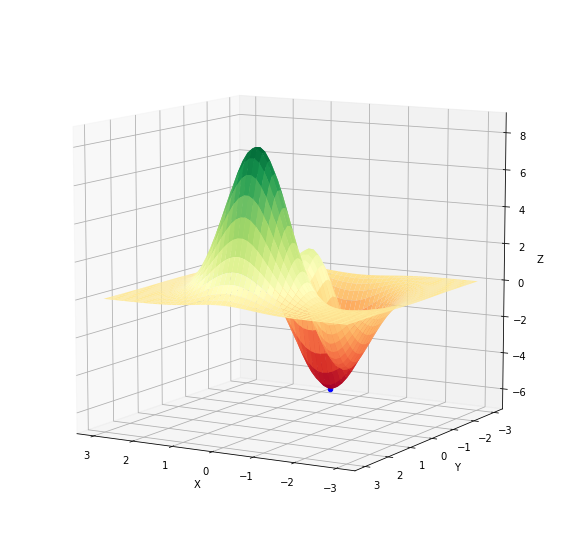

In [6]:
interval_1 = np.linspace(*domain_1, 50).reshape(-1, 1)
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.view_init(10, 120)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.plot_surface(interval_1, interval_1.T, z_points.T, edgecolor='none', cmap='RdYlGn')
ax.scatter(0.013624217270312045, -1.6617940173988675, -6.081047052559881, 'o', c='b')
plt.show()

#### 2. [1 punto] Utilice una representación de código de gray con una precisión de $10^{−5}$ para $x$ e $y$, luego imprima el fenotipo y genotipo de 10 individuos.
***Respuesta***

Una precisión de $10^{-5}$ da como resultado un espacio de búsqueda con $524288$ puntos para cada variable y una longitud de cadena de $19$ bits. 

In [7]:
print(f"Espacio de búsqueda: {points_1}x{points_1}, precisión: {eps_1:0.5f}")
POPULATION_SIZE = 10
my_population_1 = [Individual.newRandom(args_1) for _ in range(POPULATION_SIZE)]
print("Representación en Gray")
for i, ind in enumerate(my_population_1):
    print(f"Genotipo {i} = {ind.getGenotype()} Fenotipo {i} = {ind.phenotype}")

Espacio de búsqueda: 524288x524288, precisión: 0.00001
Representación en Gray
Genotipo 0 = [1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0] Fenotipo 0 = [2.518979, 1.526333]
Genotipo 1 = [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0] Fenotipo 1 = [-1.340407, -1.375995]
Genotipo 2 = [1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0] Fenotipo 2 = [0.979695, 1.796494]
Genotipo 3 = [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0] Fenotipo 3 = [-0.841446, -0.581865]
Genotipo 4 = [1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0] Fenotipo 4 = [0.333748, 2.978087]
Genotipo 5 = [1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0

#### 3. [2 punto] Para los demás parámetros simbólicos del AG Utilice: un operador de cruza/recombinación con 2 puntos de cortes aleatorios, un operador de mutación por cambio (flipping), para la selección de padres utilice el método de selección proporcional de la ruleta y para la selección de la nueva generación elimine los individuos con mayores a 5 generaciones (reemplazo generacional). Su código debe mostrar como mínimo dos individuos en los operadores de cruza (los 2 padres y los dos descendientes generados) y mutación (los individuos iniciales y los mutados).


***Respuesta***

##### Selección

Seleccion de padres utilizando el método de la Ruleta

In [8]:
class Selection(ABC):
    def __init__(self, num_individuals: int):
        self.num_individuals = num_individuals

    @abstractmethod
    def get_individuals(self, population: list[Individual], fitness: list[float]):
        pass
        
class RouletteSelection(Selection):
    def __init__(self, num_individuals: int):
        super().__init__(num_individuals)

    def get_individuals(self, population: list[Individual], fitness: list[float]):
        f_max = max(fitness)
        fitness = f_max - np.array(fitness) + 1e-4
        distribution = np.array(fitness) / sum(fitness)
        return random.choices(population, weights=distribution, k=self.num_individuals)


En la selección para la siguiente generación se están eliminado aquellos que tienen una edad mayor a 5

In [9]:
class RemoveOldSelection(Selection):
    def __init__(self, max_age: int):
        self.max_age = max_age

    def get_individuals(self, population: list[Individual]):
        new_population: list[Individual] = []
        for i in range(len(population)):
            # selecciona aquellos individuos con edad menor o igual 5 y elimina aquellos con edad mayor a 5
            if population[i].age <= self.max_age:
                new_population.append(population[i])
        return new_population


Ejemplo

In [40]:
old_p1 = my_population_1[0]
old_p1.age = 9
old_p2 = my_population_1[1]
old_p2.age = 2
old_p3 = my_population_1[2]
old_p3.age = 6
old_p4 = my_population_1[3]
old_p4.age = 3
old_population = [old_p1, old_p2, old_p3, old_p4]
print("Antes del reemplazo generacional, individuos con cualquier edad")
for i, ind in enumerate(old_population):
    print(f"Edad = {ind.age}, Individuo {i} = {ind.phenotype}")
print("\nDespués del reemplazo generacional, individuos con edad <= 5")
young_selected = RemoveOldSelection(max_age=5).get_individuals(old_population)
for i, ind in enumerate(young_selected):
    print(f"Edad = {ind.age}, Individuo {i} = {ind.phenotype}")


Antes del reemplazo generacional, individuos con cualquier edad
Edad = 9, Individuo 0 = [2.518979, 1.526333]
Edad = 2, Individuo 1 = [-1.340407, -1.375995]
Edad = 6, Individuo 2 = [0.979695, 1.796494]
Edad = 3, Individuo 3 = [-0.841446, -0.581865]

Después del reemplazo generacional, individuos con edad <= 5
Edad = 2, Individuo 0 = [-1.340407, -1.375995]
Edad = 3, Individuo 1 = [-0.841446, -0.581865]


##### Operador de cruzamiento

Se modificó la clase Cruzamiento con N puntos de laboratorios anteriores para que las edades de los individuos que son cruzados incrementen en 1 y sus hijos nazcan con edad 0. 

In [10]:
class Crossover(ABC):
    def __init__(self, probability: float):
        self.probability = probability

    @abstractmethod
    def make(self, p1: Individual, p2: Individual):
        pass
        
class NPointCrossover(Crossover):
    def __init__(self, probability: float, n: int):
        super().__init__(probability)
        self.n = n

    def make(self, p1: Individual, p2: Individual):
        # dos hijos por pareja
        if random.random() < self.probability:
            # incrementamos en uno la edad de los padres que son cruzados
            p1.age += 1
            p2.age += 1
            ps = random.sample(range(1, p1.gen_size * p1.n_var - 1), self.n)
            ps.append(0)
            ps.append(p1.gen_size * p1.n_var)
            ps = sorted(ps)
            c1 = copy.deepcopy(p1.getGenotype())
            c2 = copy.deepcopy(p2.getGenotype())
            for i in range(0, self.n + 1):
                if i % 2 == 0:
                    continue
                c1[ps[i]:ps[i + 1]], c2[ps[i]:ps[i + 1]] = c2[ps[i]:ps[i + 1]], c1[ps[i]:ps[i + 1]]
            # el hijo por defecto nace con edad 0
            return Individual.newLike(c1, p1), Individual.newLike(c2, p2)
        return None


Ejemplo

In [11]:
CROSSOVER_RATE = 1.0
crossover=NPointCrossover(probability=CROSSOVER_RATE, n=2)
p1 = my_population_1[0]
p2 = my_population_1[1]
print("2 padres")
print(f"p1 = {p1.getGenotype()}")
print(f"p2 = {p2.getGenotype()}")
c1, c2 = crossover.make(p1, p2)
print("2 hijos")
print(f"c1 = {c1.getGenotype()}")
print(f"c2 = {c2.getGenotype()}")

print("Edades")
print(f"p1 = {p1.age}, p2 = {p2.age}")
print(f"c2 = {c1.age}, c2 = {c2.age}")

2 padres
p1 = [1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
p2 = [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0]
2 hijos
c1 = [1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
c2 = [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0]
Edades
p1 = 1, p2 = 1
c2 = 0, c2 = 0


En | fueron realizado los cortes 
```
2 padres
p1 = [1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, | 1, 0, 1, 0, 0, | 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
p2 = [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, | 0, 0, 0, 1, 0, | 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0]
2 hijos
c1 = [1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, | 0, 0, 0, 1, 0, | 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
c2 = [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, | 1, 0, 1, 0, 0, | 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0]
```

##### Operador de mutación 
La clase FlippingMutacion consiste en recorrer toda la cadena del individuo y cambiar un bit con una probabilidad $p$.

In [12]:
class Mutation(ABC):
    def __init__(self, probability: float):
        self.probability = probability

    @abstractmethod
    def make(self, p1: Individual, p2: Individual):
        pass
        
class FlippingMutation(Mutation):
    def __init__(self, probability: float):
        super().__init__(probability)

    def make(self, ind: Individual):
        mut = copy.deepcopy(ind.getGenotype())
        if random.random() < self.probability:
            ind.age += 1
            # probabilidad que el bit i cambie
            p = 0.4
            for i in range(len(mut)):
                if random.random() < p:
                    mut[i] = (mut[i] + 1) % 2
            return Individual.newLike(mut, ind)
        return None

Ejemplo

In [13]:
MUTATION_RATE = 1.0
mutation = FlippingMutation(probability=MUTATION_RATE)
ind = my_population_1[0]
print("Individuo inicial")
print(f"p1 = {ind.getGenotype()}")
ind_muted = mutation.make(ind)
print("Individuo mutado")
print(f"c1 = {ind_muted.getGenotype()}")
print("Edades")
print(f"p1 = {ind.age}, c1 = {ind_muted.age}")

Individuo inicial
p1 = [1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Individuo mutado
c1 = [1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1]
Edades
p1 = 2, c1 = 0


```
Individuo inicial
p1 = [1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Mascara de probabilidades: aquellos con probabilidad 1 cambian
m1 = [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1]
Individuo mutado
c1 = [1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1]
```

##### Algoritmo genético

El algoritmo genético utiliza una función de utilidad `offline`, que consiste en seleccionar a partir de la generación $t$ los mejores individuos de cada generación (menor fitness) y obtener el promedio de ellos (promedio de mejores). Nota, el `online` está disponible pero está comentada. Se trabajará únicamente con el `offline`.

In [16]:
def genetic_algorithm(max_generation: int,
                      t: int,
                      fitness: Callable[[list[float]], float],
                      population: list[Individual],
                      selection: Selection,
                      crossover: Crossover,
                      mutation: Mutation,
                      new_gen_selection: Selection,
                      show_best=False):
    collect_best: list[Individual] = []
    # promedio de promedio
    # collect_mean_online: list[float] = []
    # promedio de mejores
    collect_offline: list[float] = []
    generation_number = 0
    while generation_number < max_generation:
        generation_number += 1
        # evaluacion de la aptitud de la población inicial (n individuos)
        population_fitness = [fitness(ind.phenotype) for ind in population]
        # seleccion de los padres (para la reproducción)
        parents = selection.get_individuals(population, population_fitness)
        # operadores de variación
        offspring: list[Individual] = []
        # crossover
        for p1, p2 in zip(parents[0::2], parents[1::2]):
            childs = crossover.make(p1, p2)
            if childs != None:
                offspring += childs
        # mutation
        for ind in parents:
            mutant = mutation.make(ind)
            if mutant != None:
                offspring.append(mutant)
        # λ individuos aptos + n padres
        population += offspring
        # imprime la generación actual
        if show_best and generation_number % int(max_generation / 10) == 0:
            print(f"Generación: {generation_number}, número de descendientes: {len(offspring)}")
        # seleccionamos al mejor individuo de cada generación para la para la grafica
        best_individual = min(population, key=lambda x: fitness(x.phenotype))
        collect_best.append(best_individual)
        # a partir de t, seleccionamos el mejor individuo para promediar
        if generation_number > t:
            # online
            # collect_mean_online.append(sum([fitness(ind.phenotype) for ind in population]))
            # offline
            collect_offline.append(fitness(best_individual.phenotype))

        # selección de los individuos para la siguiente generación: Reemplazo Generacional
        population = new_gen_selection.get_individuals(population)

    if show_best:
        plt.plot([fitness(x.phenotype) for x in collect_best], "r-")
        plt.title(f"{selection.__class__.__name__}, {crossover.__class__.__name__} & {mutation.__class__.__name__}\nGeneration number {generation_number}")
        plt.ylabel("Fitness")
        plt.xlabel("Generation")
        plt.show()
        return collect_best
    else:
        # promedio de mejores
        return sum(collect_offline) / (max_generation - t)


#### 4. [7 puntos] Optimice los parámetros numéricos de: tamaño de la población $(\mu)$ en el rango de $[10, 500]$, numero de padres seleccionados $(\lambda)$ en el rango de $[0.2, 1]\mu$, porcentaje de cruzamiento en el rango de $[0.1, 1]$, y el porcentaje de mutación en el rango de $[10^{-3}, 0.1]$. Evalúe para $30$ combinaciones haciendo una estadística de $10$ repeticiones para $50$ generaciones, su programa debe mostrar la función de utilidad.

***Respuesta***

Dado a que son muchos valores para probar (un intervalo), se hará uso de una selección de parámetros aleatorio. Se prueba una nueva combinación en cada iteración (30 combinaciones en total). Para cada combinacion se está haciendo 10 repeticiones para obtener un promedio de la función de utilidad en cada una de ellas.

Combinacion 0
Combinacion 2
Combinacion 4
Combinacion 6
Combinacion 8
Combinacion 10
Combinacion 12
Combinacion 14
Combinacion 16
Combinacion 18
Combinacion 20
Combinacion 22
Combinacion 24
Combinacion 26
Combinacion 28


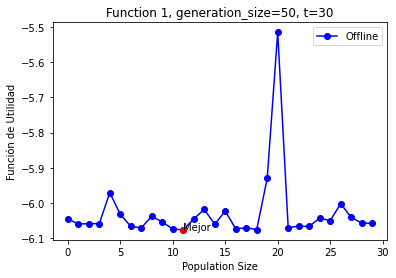

Parámetros óptimos: [i, µ, λ, Pc, Pm] =  [11, 402, 313, 0.989548042665257, 0.002180913964027161]


In [17]:
GENERACIONES = 50
# para el promedio de los últimos 20 individuos
t = GENERACIONES - 20  
# 30 combinaciones de parámetros
NRO_COMBINACIONES = 30
# estadística 
STATISTICS_SIZE = 10
# parametros_optimos = [i, mu, lambda, Pc, Pm]
parametros_optimos_1 = [0] * 5
# funcion de utilidad mínima
min_fu_1 = np.Inf
stats_fu_1 = []
for i in range(NRO_COMBINACIONES):
    # se prueba una nueva combinación en cada iteración (30 combinaciones en total)
    population_size = random.randint(10, 500)
    selection_size = int(random.uniform(0.2, 1) * population_size)
    crossover_rate = random.uniform(0.1, 1)
    mutation_rate = random.uniform(1.0e-3, 0.1)
    # para cada combinacion se está haciendo 10 repeticiones para obtener un promedio de la función de utilidad 
    offline_stat = []
    for _ in range(STATISTICS_SIZE):
        initial_population = [Individual.newRandom(args_1) for _ in range(population_size)]
        off = genetic_algorithm(max_generation=GENERACIONES,
                                t=t,
                                fitness=F1,
                                population=initial_population,
                                selection=RouletteSelection(num_individuals=selection_size),
                                crossover=NPointCrossover(probability=crossover_rate, n=2),
                                mutation=FlippingMutation(probability=mutation_rate),
                                new_gen_selection=RemoveOldSelection(max_age=5))            # selección que elimina aquellos mayores a 5 generaciones (5 < edad)
        offline_stat.append(off)
    # estadistica: promedio de las 10 funciones de utilidad offline
    mean_fu = np.array(offline_stat).mean()
    # seleccionamos aquella con menor función de utilidad
    if mean_fu < min_fu_1:
        min_fu_1 = mean_fu
        parametros_optimos_1 = [i, population_size, selection_size, crossover_rate, mutation_rate]
    # agregamos el promedio de la función de utilidad de cada combinación para gráficarlo
    stats_fu_1.append(mean_fu)
    if i % 2 == 0:
        print("Combinacion", i)
fig, axes = plt.subplots()
plt.xlabel("Population Size")
plt.ylabel("Función de Utilidad")
# plt.plot(range(len(population_size)), online, 'o-', label="Online")
axes.set_title("Function 1, generation_size=%d, t=%d" % (GENERACIONES, t))
# axes.plot(online, 'o-', label="Online", c="b")
axes.plot(stats_fu_1, 'o-', label="Offline", c="b")
axes.plot(parametros_optimos_1[0], min_fu_1, 'o', c='r')
axes.annotate(str("Mejor"), (parametros_optimos_1[0], min_fu_1))
plt.legend()
plt.show()

print("Parámetros óptimos: [i, µ, λ, Pc, Pm] = ", parametros_optimos_1)


#### 5. [4 puntos] Con los parámetros numéricos optimizados evalúe la solución para 500 generaciones, grafique la función de aptitud y explique su resultado.
Se seleccionó la mejor combinación aleatoria de parámetros. En la gráfica es el punto rojo.


population_size = 402
selection_size = 313
crossover_rate = 0.989548042665257
mutation_rate = 0.002180913964027161

Generación: 50, número de descendientes: 309
Generación: 100, número de descendientes: 313
Generación: 150, número de descendientes: 312
Generación: 200, número de descendientes: 312
Generación: 250, número de descendientes: 309
Generación: 300, número de descendientes: 306
Generación: 350, número de descendientes: 312
Generación: 400, número de descendientes: 308
Generación: 450, número de descendientes: 309
Generación: 500, número de descendientes: 307


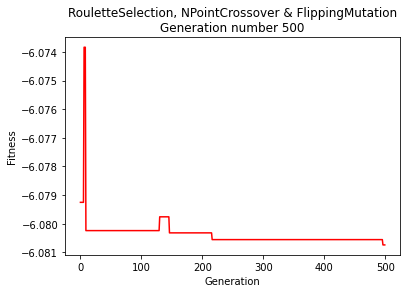

In [18]:
# GA CANONICAL HYPERPARAMETERS
MAX_GENERATION = 500
population_size_1 = parametros_optimos_1[1]
selection_size_1 = parametros_optimos_1[2]
crossover_rate_1 = parametros_optimos_1[3]
mutation_rate_1 = parametros_optimos_1[4]
print(f"""
population_size = {population_size_1}
selection_size = {selection_size_1}
crossover_rate = {crossover_rate_1}
mutation_rate = {mutation_rate_1}
""")

initial_population = [Individual.newRandom(args_1) for _ in range(population_size_1)]
best_1 = genetic_algorithm(max_generation=MAX_GENERATION,
                           t=t,
                           fitness=F1,
                           population=initial_population,
                           selection=RouletteSelection(num_individuals=selection_size_1),
                           crossover=NPointCrossover(probability=crossover_rate_1, n=2),
                           mutation=FlippingMutation(probability=mutation_rate_1),
                           new_gen_selection=RemoveOldSelection(max_age=5),
                           show_best=True)


In [19]:
solution1 = min(best_1, key=lambda x: F1(x.phenotype))
print(f"Optimal value with RouletteSelection\n x* = {solution1.phenotype}, f(x*) = {F1(solution1.phenotype)}")


Optimal value with RouletteSelection
 x* = [0.02007869735469292, -1.6591733153787906], f(x*) = -6.080741319974658


#### 6. [5 puntos] usando el mismo código replique la optimización de los parámetros numéricos y el resultado final para la función de Rastrigin con $n = 2$.

$$f(\bar{x})=10 \cdot n+\sum_{i=1}^{n}\left[x_{i}^{2}-10 \cdot \cos \left(2 \pi x_{i}\right)\right]$$

***Respuesta***

In [20]:
n = 2
# función 2
F2 = lambda x: 10 * n + sum([x[i]**2 - 10 * np.cos(2 * np.pi * x[i]) for i in range(n)])
# dominio
domain_2, n_var_2 = [-3, 3], n
# tamaño del gen
GEN_SIZE_2 = 18
# presición
eps_2 = (domain_2[1] - domain_2[0]) / (2**GEN_SIZE_2 - 1)
# los los individuos nacen con una edad 0, en cada generación esta se incrementa
age_2 = 0
# argumentos para el experimento 2
args_2 = IndividualArguments(domain_2, eps_2, n_var_2, age_2, GEN_SIZE_2)
# numero de puntos
points_2 = int((domain_2[1] - domain_2[0]) / eps_2) + 1
print(f"Espacio de búsqueda: {points_2}x{points_2}, con una presición de {eps_2:0.6f}")


Espacio de búsqueda: 262144x262144, con una presición de 0.000023


Gráfica 1: Curvas de nivel. En la barra de color se observa que el valor mínimo es aproximadamente 0 y el máximo 48.6 en el intervalo dado. El punto rojo es el mínimo encontrado con el algoritmo genético.

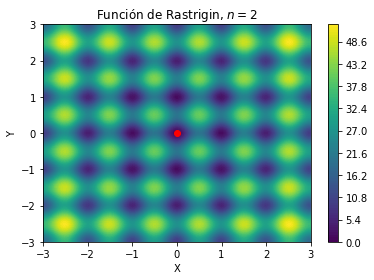

In [29]:
interval_2 = np.linspace(*domain_2, 100)
z_points_2 = np.zeros((100, 100))

for i, x in enumerate(interval_2):
    for j, y in enumerate(interval_2):
        z_points_2[j, i] = F2([interval_2[i], interval_2[j]])
plt.title(f"Función de Rastrigin, $n={n}$")
plt.contourf(interval_2, interval_2, z_points_2, 100)
# punto rojo, dato del problema
plt.plot(0.0005378743662807217, -0.0001258854899806039, 'o', c='r')
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar()
plt.show()

Gráfica 2: Función en el espacio. El punto azul es el mínimo valor encontrado con el algoritmo genético.

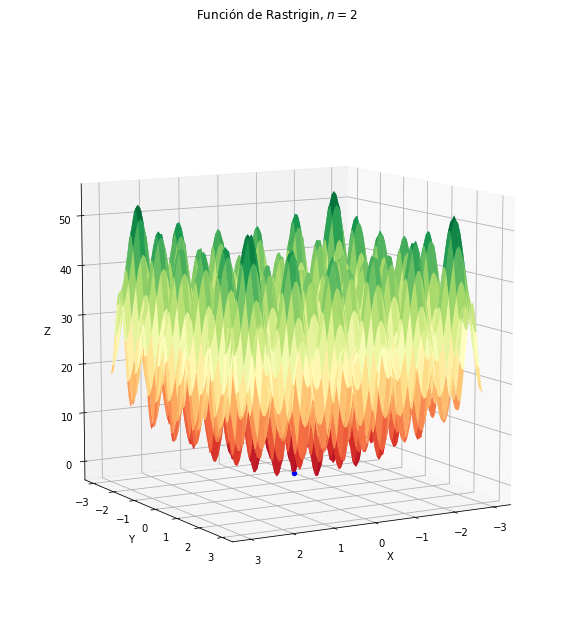

In [30]:
interval_2 = np.linspace(*domain_2, 100).reshape(-1, 1)
fig = plt.figure(figsize=(10, 10))
plt.suptitle(f"Función de Rastrigin, $n={n}$")
ax = plt.axes(projection='3d')
ax.view_init(10, 60)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.plot_surface(interval_2, interval_2.T, z_points_2.T, edgecolor='none', cmap='RdYlGn')
ax.scatter(0.0005378743662807217, -0.0001258854899806039, 0.0000605, 'o', c='b')
plt.show()

Combinacion 0
Combinacion 2
Combinacion 4
Combinacion 6
Combinacion 8
Combinacion 10
Combinacion 12
Combinacion 14
Combinacion 16
Combinacion 18
Combinacion 20
Combinacion 22
Combinacion 24
Combinacion 26
Combinacion 28


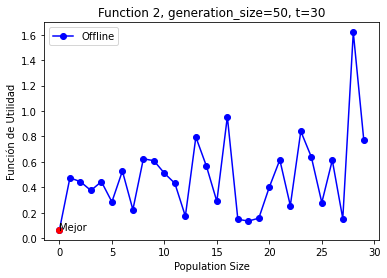

Parámetros óptimos: [i, µ, λ, Pc, Pm] =  [0, 452, 390, 0.6274320072993185, 0.05583093964536381]


In [24]:
GENERACIONES = 50
# para el promedio de los últimos 20 individuos
t = GENERACIONES - 20  
# 30 combinaciones de parámetros
NRO_COMBINACIONES = 30
# estadística 
STATISTICS_SIZE = 10
# parametros_optimos = [i, mu, lambda, Pc, Pm]
parametros_optimos_2 = [0] * 5
# funcion de utilidad mínima
min_fu_2 = np.Inf
stats_fu_2 = []
for i in range(NRO_COMBINACIONES):
    # se prueba una nueva combinación es cada iteración (30 combinaciones en total)
    population_size = random.randint(10, 500)
    selection_size = int(random.uniform(0.2, 1) * population_size)
    crossover_rate = random.uniform(0.1, 1)
    mutation_rate = random.uniform(1.0e-3, 0.1)
    # para cada combinacion se está haciendo 10 repeticiones para obtener un promedio de la función de utilidad 
    offline_stat = []
    for _ in range(STATISTICS_SIZE):
        initial_population = [Individual.newRandom(args_2) for _ in range(population_size)]
        off = genetic_algorithm(max_generation=GENERACIONES,
                                t=t,
                                fitness=F2,
                                population=initial_population,
                                selection=RouletteSelection(num_individuals=selection_size),
                                crossover=NPointCrossover(probability=crossover_rate, n=2),
                                mutation=FlippingMutation(probability=mutation_rate),
                                new_gen_selection=RemoveOldSelection(max_age=5))
        offline_stat.append(off)
    # estadistica: promedio de las 10 funciones de utilidad offline
    mean_fu = np.array(offline_stat).mean()
    # seleccionamos aquella con menor función de utilidad
    if mean_fu < min_fu_2:
        min_fu_2 = mean_fu
        parametros_optimos_2 = [i, population_size, selection_size, crossover_rate, mutation_rate]
    # agregamos el promedio de la función de utilidad de cada combinación para gráficarlo
    stats_fu_2.append(mean_fu)
    if i % 2 == 0:
        print("Combinacion", i)
fig, axes = plt.subplots()
plt.xlabel("Population Size")
plt.ylabel("Función de Utilidad")
# plt.plot(range(len(population_size)), online, 'o-', label="Online")
axes.set_title("Function 2, generation_size=%d, t=%d" % (GENERACIONES, t))
# axes.plot(online, 'o-', label="Online", c="b")
axes.plot(stats_fu_2, 'o-', label="Offline", c="b")
axes.plot(parametros_optimos_2[0], min_fu_2, 'o', c='r')
axes.annotate(str("Mejor"), (parametros_optimos_2[0], min_fu_2))
plt.legend()
plt.show()

print("Parámetros óptimos: [i, µ, λ, Pc, Pm] = ", parametros_optimos_2)



population_size = 452
selection_size = 390
crossover_rate = 0.6274320072993185
mutation_rate = 0.05583093964536381

Generación: 50, número de descendientes: 251
Generación: 100, número de descendientes: 243
Generación: 150, número de descendientes: 273
Generación: 200, número de descendientes: 265
Generación: 250, número de descendientes: 249
Generación: 300, número de descendientes: 240
Generación: 350, número de descendientes: 276
Generación: 400, número de descendientes: 286
Generación: 450, número de descendientes: 242
Generación: 500, número de descendientes: 285


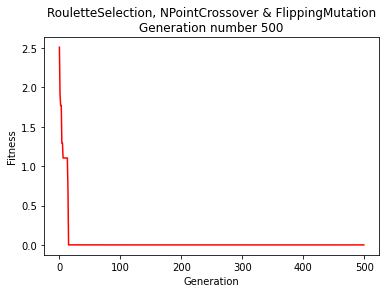

In [25]:
# GA CANONICAL HYPERPARAMETERS
MAX_GENERATION = 500
population_size_2 = parametros_optimos_2[1]
selection_size_2 = parametros_optimos_2[2]
crossover_rate_2 = parametros_optimos_2[3]
mutation_rate_2 = parametros_optimos_2[4]
print(f"""
population_size = {population_size_2}
selection_size = {selection_size_2}
crossover_rate = {crossover_rate_2}
mutation_rate = {mutation_rate_2}
""")

initial_population = [Individual.newRandom(args_2) for _ in range(population_size_2)]
best_2 = genetic_algorithm(max_generation=MAX_GENERATION,
                           t=t,
                           fitness=F2,
                           population=initial_population,
                           selection=RouletteSelection(num_individuals=selection_size_2),
                           crossover=NPointCrossover(probability=crossover_rate_2, n=2),
                           mutation=FlippingMutation(probability=mutation_rate_2),
                           new_gen_selection=RemoveOldSelection(max_age=5),
                           show_best=True)


In [28]:
solution2 = min(best_2, key=lambda x: F2(x.phenotype))
print(f"Optimal value with RouletteSelection\n x* = {solution2.phenotype}, f(x*) = {F2(solution2.phenotype):0.7f}")

Optimal value with RouletteSelection
 x* = [0.0005378743662807217, -0.0001258854899806039], f(x*) = 0.0000605
